In [448]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from reader import read_bruker_data
from spectra_manager import BaseSpectraCreator

import optimiation
import spectra_processing

reload(population)
reload(optimiation.fitter)
reload(optimiation.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimiation)

<module 'optimiation' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\optimiation\\__init__.py'>

### ИЗВЛЕЧЁМ ЭКСПЕРЕМЕНТАЛЬНЫЕ СПЕКТРЫ

In [449]:
import os
import re

import os
import re

def extract_data(folder_path):
    temperatures = []
    file_paths = []
    
    # Convert p notation to decimal for temperatures
    def parse_temp(temp_str):
        if 'p' in temp_str:
            parts = temp_str.split('p')
            return float(parts[0]) + float(parts[1]) / 10**len(parts[1])
        else:
            # Remove 'K' suffix if present
            temp_str = temp_str.rstrip('K')
            return float(temp_str)
    
    # Regex pattern to match your filename format: KY3_{temp}_{attin}.DSC/.DTA
    pattern = r'KY3_([^_]+)_[^_]+\.(DSC)$'
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Use regex to extract temperature from filename
            match = re.match(pattern, file)
            if match:
                temp_str = match.group(1)  # Extract the temperature part
                try:
                    temp = parse_temp(temp_str)
                    temperatures.append(temp)
                    file_paths.append(os.path.join(root, file))
                except ValueError as e:
                    print(f"Could not parse temperature from {file}: {e}")
            else:
                print(f"File {file} does not match expected pattern")
    
    return temperatures, file_paths

In [450]:
folder = r"D:\ITC\Эксперементы_на_ЭПР_спектрометре\2025_EPR\Qband_Ksenia_2025_07_11\Qband_Ksenia_2025_07_11\KY3\up"

In [451]:
temperatures, file_paths = extract_data(folder)
results = []
for path in file_paths:
    areas = ((0.0, 1.0), (1.35, 1.5))
    meta, data = read_bruker_data(path)
    x_values = data["x_values"] / 1e4
    data["x_values"] = x_values
    y_values = data["y_values"]
    y_values, _ = spectra_processing.correct_baseline(x_values, y_values, areas, poly_order=1)
    y_values = y_values / max(y_values)
    data["y_values"] = y_values
    results.append((meta, data))

File KY3_107K_30dB.DTA does not match expected pattern
File KY3_10K_35dB.DTA does not match expected pattern
File KY3_113K_30dB.DTA does not match expected pattern
File KY3_123K_30dB.DTA does not match expected pattern
File KY3_136K_30dB.DTA does not match expected pattern
File KY3_152K_30dB.DTA does not match expected pattern
File KY3_175K_30dB.DTA does not match expected pattern
File KY3_20K_30dB.DTA does not match expected pattern
File KY3_210K_30dB.DTA does not match expected pattern
File KY3_36K_30dB.DTA does not match expected pattern
File KY3_4K_35dB.DTA does not match expected pattern
File KY3_52K_30dB.DTA does not match expected pattern
File KY3_67K_30dB.DTA does not match expected pattern
File KY3_6K_35dB.DTA does not match expected pattern
File KY3_80K_30dB.DTA does not match expected pattern
File KY3_90K_30dB.DTA does not match expected pattern
File KY3_96K_30dB.DTA does not match expected pattern


### Зададим спиновую систему

Спиновая система - это три элетронных спина с разными g-тензорами. Один изотропный, и два анизотропных. При температруе порядка 100К в системе наблюдается стркутрынй переход - изменяются обменные энергии и g-tensor branching меди.

При этом ориентация g-тензоров медей известна из струкутруного анализа

In [454]:
fixed_parameters = {}

fixed_parameters["g_rad"] = 2.002

fixed_parameters["J_chain_high_temp"] = 1.4
fixed_parameters["J_branching_high_temp"] = -4.21

fixed_parameters["J_chain_low_temp"] = 1.9
fixed_parameters["J_branching_low_temp"] = -0.23


orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)
fixed_parameters["orien_side_up"] = orien_side_up
fixed_parameters["orien_chain_left"] = orien_chain_left


varies_parameters = []
varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_interchain_x", (2.00, 2.14), 2.05)
)
varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_interchain_y", (2.00, 2.14), 2.05)
)
varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_interchain_z", (2.20, 2.31), 2.20)
)


varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_branching_high_temp_x", (2.00, 2.31), 2.20)
)
varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_branching_high_temp_y", (2.00, 2.31), 2.20)
)
varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_branching_high_temp_z", (2.00, 2.31), 2.20)
)


varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_branching_low_temp_x", (2.00, 2.31), 2.20)
)
varies_parameters.append(
    optimiation.fitter.ParamSpec("g_cu_branching_low_temp_z", (2.00, 2.31), 2.20)
)

varies_parameters.append(
    optimiation.fitter.ParamSpec("delta_g", (-0.01, 0.01), 0.0)
) # Здесь по задаче считается, что <g *g > меняется слабо



varies_parameters.append(
    optimiation.fitter.ParamSpec("lorentz_high_temp", (0.00, 0.01), 0.0001)
)

varies_parameters.append(
    optimiation.fitter.ParamSpec("gauss_high_temp", (0.00, 0.01), 0.0001)
)

varies_parameters.append(
    optimiation.fitter.ParamSpec("h_strain_high_temp", (0.00, 0.01), 0.0001)
)


varies_parameters.append(
    optimiation.fitter.ParamSpec("lorentz_low_temp", (0.00, 0.01), 0.0001)
)

varies_parameters.append(
    optimiation.fitter.ParamSpec("gauss_low_temp", (0.00, 0.01), 0.0001)
)

varies_parameters.append(
    optimiation.fitter.ParamSpec("h_strain_low_temp", (0.00, 0.01), 0.0001)
)


param_space = optimiation.fitter.ParameterSpace(varies_parameters, fixed_parameters)

### Подгрузим эксперементальные данные - 136K и 90K спектры

In [455]:
###### Эксперементальные данные, которые будут использованы

idx_high = 4
fields_high = results[idx_high][1]["x_values"][300:-300]
y_exp_high = results[idx_high][1]["y_values"][300:-300]
freq_high = results[idx_high][0]["MWFQ"]
temp_high = temperatures[idx_high]


idx_low = -2
fields_low = results[idx_low][1]["x_values"][300:-300]
y_exp_low = results[idx_low][1]["y_values"][300:-300]
freq_low = results[idx_low][0]["MWFQ"]
temp_low = temperatures[idx_low]

Нужно задать метод, который строит спектры. У меня это

from functools import partial

simulate_spectra_partial = partial(
        simulate_spectra,
        mesh=mesh,
        freq_high_temp=freq_high,
        freq_low_temp=freq_low,
        high_temp=temp_high,
        low_temp=temp_low
)

partial я использую, чтобы передать всякие эксперементальный опции. Потом, на следующей итерации подумаю, как это лучше сделать



In [456]:
def build_sample(
    J_chain, J_branching,
    g_rad, g_cu_chain, g_cu_branching,
    orient_side, orient_up, h_strain,
    rotation_matrices
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(g_cu_chain_tensor, g1_frame)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, orient_up)
        
        g_rad = torch.full((3,), g_rad)
        g_rad_frame = torch.tensor([0, 0, 0])
        zeem_rad = spin_system.Interaction(g_rad, g_rad_frame)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        e_rad = particles.Electron(spin=0.5)
        
        J_chain = 2 * J_chain # Because 2 S1 S2
        J_chain_hz = (J_chain * 100) * 3 * 1e8
        inter_chain = torch.full((3,), J_chain_hz)
        d_frame = torch.zeros(3)
        ee_int_chain = spin_system.Interaction(inter_chain, d_frame, torch.zeros(3))

        J_branching = 2 * J_branching # Because 2 S1 S2
        J_branching_hz = (J_branching * 100) * 3 * 1e8
        inter_side = torch.full((3,), J_branching_hz)
        d_frame = torch.zeros(3)
        ee_int_side = spin_system.Interaction(inter_side, d_frame, torch.zeros(3))
        
        system = spin_system.SpinSystem(
            electrons=[e_rad, e_chain, e_branching],
            g_tensors=[zeem_rad, zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_side), (0, 2, ee_int_chain)
            ]
        )

        # Homogeneity strain
        hum_str = h_strain * torch.ones(3)
        return spin_system.MultiOrientedSample(system, hum_str, rotation_matrices)


def simulate_spectra(
    magnetic_fields,
    params,
    freq_high_temp,
    freq_low_temp,
    high_temp,
    low_temp, mesh
):
    B_high = magnetic_fields[0]
    B_low = magnetic_fields[1]
    rotation_matrices = mesh.create_rotation_matrices()

    g_cu_chain = torch.tensor(
        [params["g_cu_interchain_x"],
         params["g_cu_interchain_y"],
         params["g_cu_interchain_z"]]
        )
    
    g_cu_branching_high_temp = torch.tensor(
        [params["g_cu_branching_high_temp_x"],
         params["g_cu_branching_high_temp_y"],
         params["g_cu_branching_high_temp_z"]]
    )
    
    delta_g = params["delta_g"]
    g_cu_branching_low_temp_x = params["g_cu_branching_low_temp_x"]
    g_cu_branching_low_temp_z = params["g_cu_branching_low_temp_z"]
    
    g_cu__intra_sq =  sum(g_cu_branching_high_temp ** 2)
    g_cu_branching_low_temp_y =\
    g_cu__intra_sq - g_cu_branching_low_temp_x ** 2 - g_cu_branching_low_temp_z**2  + delta_g
    g_cu_branching_low_temp_y = g_cu_branching_low_temp_y ** 0.5 
    
    g_cu_branching_low_temp = torch.tensor(
        [params["g_cu_branching_high_temp_x"],
         g_cu_branching_low_temp_y,
         params["g_cu_branching_high_temp_z"]]
    )
    
    powder_high_temp = build_sample(
        J_chain=params["J_chain_high_temp"],
        J_branching=params["J_branching_high_temp"],
        g_rad=params["g_rad"],
        g_cu_chain = g_cu_chain,
        g_cu_branching = g_cu_branching_high_temp,
        orient_side=params["orien_side_up"],
        orient_up=params["orien_chain_left"],
        h_strain=params["h_strain_high_temp"],
        rotation_matrices=rotation_matrices
    )
    
    powder_low_temp = build_sample(
        J_chain=params["J_chain_low_temp"],
        J_branching=params["J_branching_low_temp"],
        g_rad=params["g_rad"],
        g_cu_chain = g_cu_chain,
        g_cu_branching = g_cu_branching_low_temp,
        orient_side=params["orien_side_up"],
        orient_up=params["orien_chain_left"],
        h_strain=params["h_strain_low_temp"],
        rotation_matrices=rotation_matrices
    )
    
    spec_high = create_temp_spectra(powder_high_temp,
                                    mesh, B_high,
                                    torch.tensor(freq_high_temp),
                                    torch.tensor(params["lorentz_high_temp"]),
                                    torch.tensor(params["gauss_high_temp"]),
                                    temperature=torch.tensor(high_temp),
                                   )
    
    spec_low = create_temp_spectra(powder_low_temp,
                                    mesh, B_low,
                                    torch.tensor(freq_low_temp),
                                    torch.tensor(params["lorentz_low_temp"]),
                                    torch.tensor(params["gauss_low_temp"]),
                                    temperature=torch.tensor(low_temp),
                                   )
    return [spec_high, spec_low]

def create_temp_spectra(powder, mesh, B, res_freq, gauss, lorentz, temperature):
    post_spectra_processor = spectra_manager.PostSpectraProcessing(gauss, lorentz)
    populator = population.StationaryPopulator(temperature)
    intensity_calculator = spectra_manager.StationaryIntensitiesCalculator(
    powder.spin_system.dim, populator=populator)
    creator = spectra_manager.BaseSpectraCreator(powder.spin_system.dim, (), mesh, 
                                                 post_spectra_processor=post_spectra_processor,
                                                 intensity_calculator=intensity_calculator)
    spec = creator(powder, res_freq, B)
    return spec

### Создадим объект fitter и зафитируем спектры

In [457]:
from functools import partial

mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2 * np.pi),
                                    initial_grid_frequency=25,
                                    interpolate=False)

simulate_spectra_partial = partial(
        simulate_spectra,
        mesh=mesh,
        freq_high_temp=freq_high,
        freq_low_temp=freq_low,
        high_temp=temp_high,
        low_temp=temp_low
)

fitter = optimiation.SpectrumFitter(
    B=[fields_high, fields_low],
    y_exp=[y_exp_high, y_exp_low],
    param_space=param_space,
    simulate_spectrum_callable=simulate_spectra_partial
)

In [458]:
result = fitter.fit(n_trials=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

### Сравним с эксперементальынми спектарми

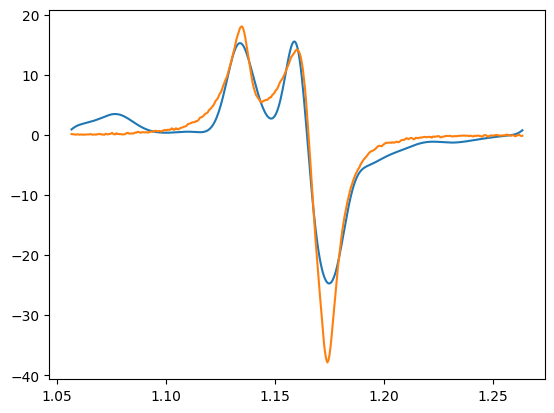

In [459]:
plt.plot(fitter.B[0].numpy(), result.best_spectrum[0].numpy())
plt.plot(fitter.B[0].numpy(), fitter.y_exp[0].numpy())

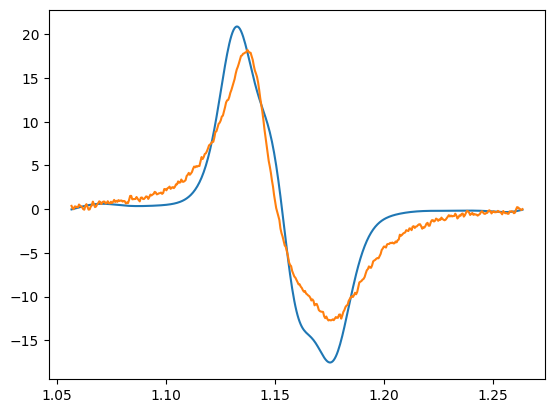

In [460]:
plt.plot(fitter.B[1].numpy(), result.best_spectrum[1].numpy())
plt.plot(fitter.B[1].numpy(), fitter.y_exp[1].numpy())

### как-то в попадаетresult.best_params. В целом, в финильной статье выглядит немного лучше

In [467]:
result.best_params # Тут получились совсем другие параметры.

{'g_cu_interchain_x': 2.060739605401563,
 'g_cu_interchain_y': 2.0894993455319524,
 'g_cu_interchain_z': 2.2892264051120175,
 'g_cu_branching_high_temp_x': 2.0005787678991935,
 'g_cu_branching_high_temp_y': 2.193800751571051,
 'g_cu_branching_high_temp_z': 2.2825583215276337,
 'g_cu_branching_low_temp_x': 2.1610694603722185,
 'g_cu_branching_low_temp_z': 2.0802921879891345,
 'delta_g': -0.0026834389075095933,
 'lorentz_high_temp': 0.0026074074163860506,
 'gauss_high_temp': 0.004055534746363397,
 'h_strain_high_temp': 0.009888151642254137,
 'lorentz_low_temp': 0.005967259946349028,
 'gauss_low_temp': 0.006323040107505489,
 'h_strain_low_temp': 0.009757914488591904}

Теперь попробуем поискать другие минимумы, с другими g-тензорами. Оставим только их имена

In [469]:
space_searcher = optimiation.fitter.SpaceSearcher()
param_names = ['g_cu_interchain_x',
                 'g_cu_interchain_y',
                 'g_cu_interchain_z',
                 'g_cu_branching_high_temp_x',
                 'g_cu_branching_high_temp_y',
                 'g_cu_branching_high_temp_z', 
                 'g_cu_branching_low_temp_x',
                 'g_cu_branching_low_temp_z'
                ]
searcher_result = space_searcher(result.optimizer_info["study"], param_names)

In [480]:
searcher_result[1]["params"]

{'g_cu_interchain_x': 2.086460144763321,
 'g_cu_interchain_y': 2.0675146767937833,
 'g_cu_interchain_z': 2.285527519447461,
 'g_cu_branching_high_temp_x': 2.1716763123797853,
 'g_cu_branching_high_temp_y': 2.2373090850641546,
 'g_cu_branching_high_temp_z': 2.09127187655761,
 'g_cu_branching_low_temp_x': 2.1485460168273374,
 'g_cu_branching_low_temp_z': 2.0954477244505347,
 'delta_g': 0.0031006620661142388,
 'lorentz_high_temp': 0.005546924604427954,
 'gauss_high_temp': 0.0008991320456773809,
 'h_strain_high_temp': 0.009413558066561958,
 'lorentz_low_temp': 0.00958116419761588,
 'gauss_low_temp': 0.005629291659681643,
 'h_strain_low_temp': 0.009167145241406757}

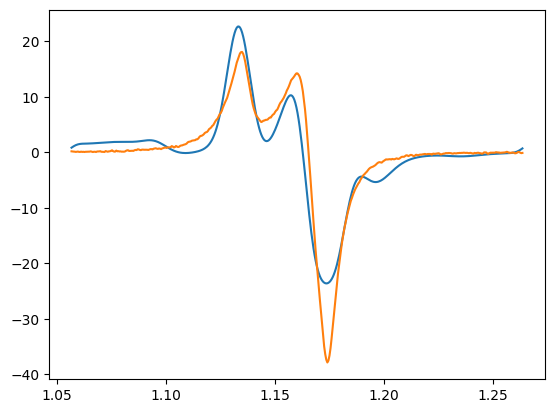

In [476]:
spec_high, spec_low = fitter.simulate_spectra_from_trial_params(searcher_result[1]["params"])

plt.plot(fitter.B[0].numpy(), spec_high.numpy())
plt.plot(fitter.B[0].numpy(), fitter.y_exp[0].numpy())

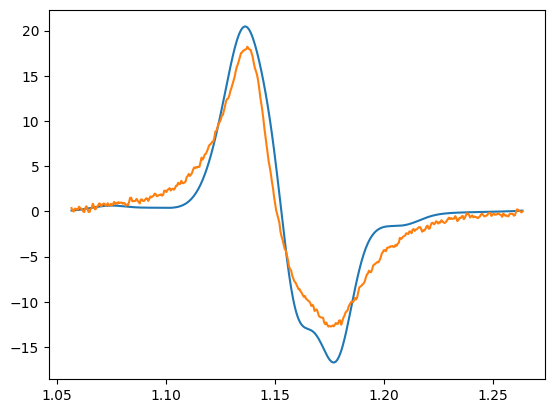

In [477]:
spec_high, spec_low = fitter.simulate_spectra_from_trial_params(searcher_result[1]["params"])

plt.plot(fitter.B[1].numpy(), spec_low.numpy())
plt.plot(fitter.B[1].numpy(), fitter.y_exp[1].numpy())